# Apresentação:

    Passada a etapa de pré-processamento dos dados, ou seja, toda essa parte
    da transformação de sequências em vetores numéricos, aqui de fato vamos
    entrar na parte de treinamento (Fine-tuning) do modelo.
  
**Nota:**

    Aqui as diferenças entre usar pytorch e Tensorflow são significativas
    o suficiente para eu preferir dividir em dois notebooks diferente. Deste
    modo, faremos aqui o fine-tuning do modelo utilizando o pytorch.

Documentação: https://huggingface.co/docs/transformers/index

**Treinamento do Modelo:**

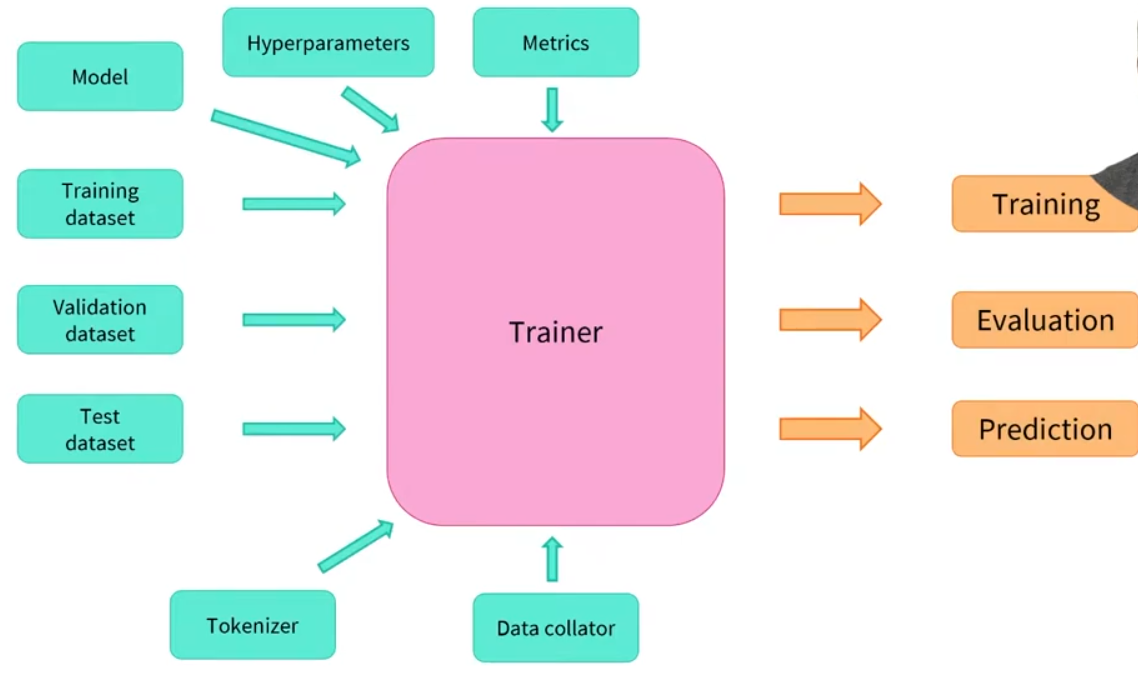

**Sobre o Dataset de Validação**

    A necessidade de um conjunto de validação costuma surgir em
    situações onde há hiperparâmetros a serem ajustados durante
    o treinamento do modelo. Deste modo, poderiamos pensar os
    conjuntos como:

Conjunto de dados de treinamento:

    Conjunto usado para treinar o modelo. Os exemplos neste conjunto são
    usados para ajustar os parâmetros do modelo de forma que ele aprenda
    a relação entre as entradas e as saídas desejadas. Quanto mais dados
    de treinamento forem fornecidos, geralmente melhor será o desempenho
    do modelo, desde que esses dados sejam representativos do problema que
    o modelo está tentando resolver.

Conjunto de dados de teste:

    Este conjunto continua tendo a mesma ideia do tradicional em Machine
    Leraning, avaliar o desempenho do modelo após o treinamento. Ele é
    separado do conjunto de treinamento e não é usado durante o treinamento
    do modelo. Isso é importante para garantir que o modelo não esteja
    simplesmente memorizando os dados de treinamento, mas sim generalizando
    bem para novos dados. O conjunto de teste fornece uma avaliação imparcial
    do desempenho do modelo em dados não vistos anteriormente.

Conjunto de dados de validação:

    O conjunto de validação é a novidade aqui. É usado para ajustar os
    hiperparâmetros do modelo durante o treinamento. Hiperparâmetros são
    configurações que controlam o processo de treinamento, como a taxa de
    aprendizado ou o número de camadas em uma rede neural. Ao ajustar os
    hiperparâmetros com base no desempenho do modelo no conjunto de validação,
    é possível evitar o superajuste (overfitting) aos dados de treinamento
    e otimizar o desempenho geral do modelo em novos dados.

Em resumo,

    Se você tiver costume com Machine Learning, vai lembrar que lá, o processo
    de otimização de hiperparâmtros é feito antes do treinamento do modelo
    em si e a técnica que se costuma usar nessa situação é a validação
    cruzada (cross-validation). Geralmente, modelos de duas camadas são
    funcionam dessa forma.

    Já para modelos multicamadas, sobretudo nessa parte de LLMs, costuma-se
    fazer a otimização dos hiperparâmetros junto com o treinamento do modelo.
    Quando esse é o caso, surge então a necessidade de ter um conjunto de
    teste para os hiperparâmetros, o nosso conjunto de validação.



    

In [1]:
# Instantando os datasets:
!pip install datasets

  Using cached datasets-2.18.0-py3-none-any.whl.metadata (20 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.4.1-cp39-cp39-win_amd64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py39-none-any.whl.metadata (7.2 kB)
Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
   ---------------------------------------- 0.0/24.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.9 MB 1.3 MB/s eta 0:00:20
    --------------------------------------- 0.4/24.9 MB 4.4 MB/s eta 0:00:06
   --- ------------------------------------ 2.4/24.9 MB 19.5 MB/s eta 0:00:02
   -------- ------------------------------- 5.4/24.9 MB 31.3 MB/s eta 0:00:01
   ------------- -------------------------- 8.4/24.9 MB 38.1 MB/s eta 0:00:01
   ------------------ --------------------- 11.3/24.9 MB 65.6 MB/s eta 0:00:01
   --------------------

# Treinando um modelo:


    A classe fornecida pela 🤗 Transformers para o treinamento do modelo é a
    Trainer que irá ajudar a aplicação do fine-tuning a qualquer um dos modelos
    pré-treinados. O código aqui utilizado será um resumo do que foi visto na
    parte de pré-processamento dos dados.

    O curso também recomenda a utilização de GPU nessa parte de treinamento,
    devido ao elevado custo computacional. Esse dilema da utilização da GPU
    é algo que importante no universo de treinamento de grandes modelos.

Documentação: https://huggingface.co/docs/transformers/v4.39.3/en/main_classes/trainer#trainer




In [2]:
# Importando dependências:
from datasets import load_dataset # Conjunto de dados:

3,.from transformers import AutoTokenizer, DataCollatorWithPadding

# Carregando o conjunto de dados:
raw_datasets = load_dataset("glue", "mrpc")

# Definindo o modelol pelo checkpoint:
checkpoint = "bert-base-uncased"

# Instanciando a classe do tokenizador:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Definindo uma função para tokenizar os exemplos do conjunto de dados.
def tokenize_function(example):
  '''
    Função construida para facilitar o
  processo de tokenização das sentenças.

  Args:
  Nosso conjunto de dado estruturado em tabela arrow, estrutura
  de dados que o Hugging Face utiliza para disponibiliza seus datasets.

  Outpus:
  Os vetores de input_ids, token_type_ids e attention_mask em estruturados
  numa estrutura semelhante a um dicionário forma organizados em um dicionário.
  '''

  return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

# Aplicando a função de tokenização a todos os exemplos do conjunto de dados, em lotes.
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True) # Map aqui é um método da Classe.

# Instanciando objeto DataCollatorWithPadding:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

**Treinamento**

    O primeiro passo antes de podermos definir nosso Trainer é definir
    uma classe TrainingArguments que conterá todos os hiperparâmetros que
    o Trainer usará para treinamento e avaliação. O único argumento que você
    precisa fornecer é um diretório onde o modelo treinado será salvo, bem
    como os checkpoints ao longo do caminho. Para todo o resto, você pode
    deixar os valores padrão, que devem funcionar muito bem para um ajuste
    fino básico.

In [1]:
import transformers
transformers.__version__h

'4.39.3'

In [3]:
# Importando Dependências:
from transformers import TrainingArguments

# Instanciando TrainingArguments:
training_args = TrainingArguments("test-trainer")

**TrainingArguments**

    TrainingArguments é uma classe que encapsula os argumentos necessários
    para configurar e executar o treinamento de um modelo de linguagem ou de
    aprendizado profundo usando a classe Trainer.
    
Dito isso:

    O segundo passo é definir nosso modelo. Como no capítulo anterior,
    vamos usar a classe AutoModelForSequenceClassification, com dois rótulos:

In [4]:
# Importando a classe automodel para Classificação:
from transformers import AutoModelForSequenceClassification

# Intanciando modelo:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Note**

    Podemos notar que, ao contrário do Capítulo 2, recebemos um aviso após instanciar este modelo pré-treinado.
    Isso ocorre porque o BERT não foi pré-treinado para classificar pares de frases, então a cabeça do modelo
    pré-treinado foi descartada e uma nova cabeça adequada para classificação de sequência foi adicionada em seu
    lugar. Os avisos indicam que alguns pesos não foram utilizados (os correspondentes à cabeça de pré-treinamento
    descartada) e que outros foram inicializados aleatoriamente (para a nova cabeça). A ideia aqui é justamente
    treinar esse modelo para essa nova cabeça.

    Uma vez que temos nosso modelo, podemos definir um Trainer passando todos os objetos construídos até agora:
    O modelo, os training_args, os conjuntos de dados de treinamento e validação, nosso data_collator e nosso tokenizer.

In [5]:
# Importando a Classe de treino:
from transformers import Trainer

# Instanciando Trainer:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

    Observe que quando você passa o tokenizer como fizemos aqui, o data_collator padrão
    usado pelo Trainer será um DataCollatorWithPadding como definido anteriormente, então
    você pode pular a linha data_collator=data_collator nesta chamada. Ainda era importante
    mostrar esta parte do processamento na seção 2!

    Feito tudo isso, para realizar o fine-tuning do modelo tendo em vista o nosso conjunto
    de dados, basta chamar o método train() do nosso Trainer:

In [6]:
# Fit:
trainer.train()

Step,Training Loss
500,0.501500
1000,0.285000


Checkpoint destination directory test-trainer\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-trainer\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1377, training_loss=0.3233084308122844, metrics={'train_runtime': 2406.6242, 'train_samples_per_second': 4.572, 'train_steps_per_second': 0.572, 'total_flos': 405258858573360.0, 'train_loss': 0.3233084308122844, 'epoch': 3.0})

In [ ]:
,